# Running before

In [ ]:
%load_ext autoreload
%autoreload 2
from plot import *
import sys
sys.path.append("../lib")
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from matplotlib.colors import LinearSegmentedColormap
import sys 
import numpy as np
import jax
import jax.numpy as jnp
import jax
jax.config.update("jax_platform_name", "cpu")
import matplotlib.pyplot as plt
rgb_values = [
    [231, 98, 84],
    [239, 138, 71],
    [247, 170, 88],
    [255, 208, 111],
    [255, 230, 183],
    [170, 220, 224],
    [114, 188, 213],
    [82, 143, 173],
    [55, 103, 149],
    [30, 70, 110]
]
colors = [[x / 255 for x in rgb] for rgb in rgb_values]
colors_line = [
    (55/255, 103/255, 149/255),    # #c7522a
    (114/255, 188/255, 213/255),  # #e5c185
    (247/255, 170/255, 88/255),  # #fbf2c4
    (231/255, 98/255, 84/255)     # #008585
]
colors_line2 = [
    (189/255, 60/255, 51/255),    # #c7522a
    (63/255, 96/255, 163/255),  # #e5c185
]
params = {
    'axes.labelsize': 24,
    'font.size': 22,
    'lines.linewidth': 1.5,
    'legend.fontsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'text.usetex': False,
    'figure.figsize': [8, 6],
    'axes.linewidth': 1.5
}
plt.rcParams.update(params)
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=10)
cmap256 = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)
from notion_client import Client
notion = Client(auth="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")
database_id = "1f8fc9067a748057a9ebf052fd25a8bd"
response = notion.databases.query(
    database_id=database_id,
    page_size=100
)


In [2]:
import os
import pickle
def save_pickle(obj, filename):
    """
    Save object to a pickle file
    """
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, "wb") as f:
        pickle.dump(obj, f)
    print(f"[Saved] {filename}")
def load_pickle(filename):
    """
    Load object from a pickle file
    """
    with open(filename, "rb") as f:
        obj = pickle.load(f)
    print(f"[Loaded] {filename}")
    return obj
all_results_mul = load_pickle("SavedResults/all_results.pkl")
merged_by_axis_type_mul = load_pickle("SavedResults/merged_by_axis_type_mul.pkl")
all_results = load_pickle("SavedResults/all_results_non.pkl")
merged_by_axis_type = load_pickle("SavedResults/merged_by_axis_type.pkl")

[Loaded] SavedResults/all_results.pkl
[Loaded] SavedResults/merged_by_axis_type_mul.pkl
[Loaded] SavedResults/all_results_non.pkl
[Loaded] SavedResults/merged_by_axis_type.pkl


In [3]:
def build_axis_type_with_source(merged_non, merged_mul,
                                key_non="no_multipole",
                                key_mul="with_multipole"):
    """
    merged_non:  merged_by_axis_type()
    merged_mul:  merged_by_axis_type_mul()
    Returns:
        combined[axis_type][model][source_key] = {"Rcusp":..., "phi":..., "w":...}
    """
    combined = {}
    for axis_type, models_dict in merged_non.items():  # "long_axis", "short_axis"
        combined[axis_type] = {}
        for model in models_dict.keys():               # "None", "CDM", "SIDM", "FDM"
            combined[axis_type][model] = {
                key_non: merged_non[axis_type][model],
                key_mul: merged_mul[axis_type][model],
            }
    return combined
merged_by_axis_type_both = build_axis_type_with_source(
    merged_by_axis_type,
    merged_by_axis_type_mul
)

In [4]:
from Bayesian import *
def choose_observation(axis_type_name):
    for sim_dict in merged_by_axis_type_both.items():
        axis_filter = None
        if axis_type_name == "short_axis":
            axis_filter = "short"
        elif axis_type_name == "long_axis":
            axis_filter = "long"
        observations = make_observations_from_notion(
            notion_response=response,
            axis_filter=axis_filter,
            rcusp_max=1,
            require_sigma=False,
            # exclude_names=['J1042', 'B2045']
        )
        print(f"\nTarget Plot axis_type: {axis_type_name}")
        print(f"Count Extracted observations {len(observations)} ")
    return observations 

In [5]:
def build_sim_samples_for_axis_with_weights(
    sim_dict,
    sim_type_list,
    sim_dict_mul=None,
    suffix_mul="_mul"
):
    """
    sim_dict      :  merged_by_axis_type[axis_type_name]
    sim_dict_mul  :  merged_by_axis_type_mul[axis_type_name] ()
    sim_type_list : ["None", "CDM", "SIDM", "FDM"]
    """
    sim_samples = {}
    for sim_type in sim_type_list:
        if sim_type not in sim_dict:
            continue
        R = sim_dict[sim_type]["Rcusp"]
        P = sim_dict[sim_type]["phi"]
        W = sim_dict[sim_type]["w"]
        if R.size > 0:
            sim_samples[sim_type] = {"R": R, "phi": P, "w": W}
    if sim_dict_mul is not None:
        for sim_type in sim_type_list:
            if sim_type not in sim_dict_mul:
                continue
            Rm = sim_dict_mul[sim_type]["Rcusp"]
            Pm = sim_dict_mul[sim_type]["phi"]
            Wm = sim_dict_mul[sim_type]["w"]
            if Rm.size > 0:
                key = sim_type + suffix_mul
                sim_samples[key] = {"R": Rm, "phi": Pm, "w": Wm}
    return sim_samples


In [6]:
def format_BF_from_log10(log10_bf, thresh=1e3):
    """
    Input: log10(BF)
    Output:
      - BF < thresh:  ()
      - BF >= thresh: 10^{n} (n )
    """
    bf = 10 ** log10_bf
    if bf < thresh:
        if bf >= 10:
            return f"{bf:.0f}"
        elif bf >= 1:
            return f"{bf:.1f}"
        else:
            return f"{bf:.2g}"
    else:
        n = int(np.round(log10_bf))
        return rf"$10^{{{n}}}$"

# plot

In [7]:
axis_type_name = "long_axis"
observations = choose_observation(axis_type_name)
names = [o.get("name", "UNKNOWN") for o in observations]
print(f"Target Plot axis_type: {axis_type_name}")
print(f"Count Extracted observations {len(observations)} ")
print(names)
sim_samples = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type[axis_type_name],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul[axis_type_name],
)
# print(sim_samples.keys())
result_long_axis = kde_marginal_likelihood_2d_weighted(
    sim_samples,
    observations,
    ref_model="FDM_mul",
    bw_method="scott"
)
print(result_long_axis)


🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个

🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个
🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个
['B1608', 'J0147', 'J0429', 'J1433', 'B2045', 'Q1131', 'B1422', 'J0833', 'J0630']


{'Z': {'None': 4.58711930711535e-26, 'CDM': 7.789136501679357e-20, 'SIDM': 2.2702254459440545e-19, 'FDM': 1.8009115752231364e-17, 'None_mul': 2.681097653717263e-34, 'CDM_mul': 4.489446816433285e-21, 'SIDM_mul': 2.985308197409233e-20, 'FDM_mul': 5.566774370230488e-19}, 'logZ': {'None': -58.34396019273292, 'CDM': -43.998971853166715, 'SIDM': -42.92923762493115, 'FDM': -38.555653613509875, 'None_mul': -77.30166687884406, 'CDM_mul': -46.85255746217794, 'SIDM_mul': -44.95799886965282, 'FDM_mul': -42.03230098837384}, 'BF_vs_ref': {'None': 8.240174654187438e-08, 'CDM': 0.1399219006132784, 'SIDM': 0.40781703998720853, 'FDM': 32.35107901721138, 'None_mul': 4.8162499059688925e-16, 'CDM_mul': 0.00806471848480434, 'SIDM_mul': 0.05362725339424217, 'FDM_mul': 1.0}, 'log10_BF': {'None': -7.084063583139536, 'CDM': -0.8541143042994416, 'SIDM': -0.38953463187370074, 'FDM': 1.5098887704268464, 'None_mul': -15.317290986457985, 'CDM_mul': -2.0934107879315476, 'SIDM_mul': -1.2706144455554955, 'FDM_mul': 0.0

In [8]:
observations

[{'R': 0.4916,
  'phi': 105.87,
  'sigma_R': 0.0006,
  'sigma_phi': 0.43,
  'name': 'B1608'},
 {'R': 0.00311,
  'phi': 67.07,
  'sigma_R': 0.0059,
  'sigma_phi': 0.11,
  'name': 'J0147'},
 {'R': 0.386,
  'phi': 87.32,
  'sigma_R': 0.002,
  'sigma_phi': 0.21,
  'name': 'J0429'},
 {'R': 0.339,
  'phi': 126.59,
  'sigma_R': 0.003,
  'sigma_phi': 0.076,
  'name': 'J1433'},
 {'R': 0.5137,
  'phi': 35.3,
  'sigma_R': 0.0003,
  'sigma_phi': 0.04,
  'name': 'B2045'},
 {'R': 0.0204,
  'phi': 66.12,
  'sigma_R': 0.0184,
  'sigma_phi': 0.05,
  'name': 'Q1131'},
 {'R': 0.15,
  'phi': 74.32,
  'sigma_R': 0.006,
  'sigma_phi': 0.76,
  'name': 'B1422'},
 {'R': 0.342,
  'phi': 86.63,
  'sigma_R': 0.004,
  'sigma_phi': 0.62,
  'name': 'J0833'},
 {'R': 0.288,
  'phi': 73.83,
  'sigma_R': 0.001,
  'sigma_phi': 0.6,
  'name': 'J0630'}]

In [9]:
axis_type_name = "short_axis"
observations = choose_observation(axis_type_name)
names = [o.get("name", "UNKNOWN") for o in observations]
print(f"Target Plot axis_type: {axis_type_name}")
print(f"Count Extracted observations {len(observations)} ")
print(names)
print(observations)
sim_samples = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type[axis_type_name],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul[axis_type_name],
)
result_short_axis = kde_marginal_likelihood_2d_weighted(
    sim_samples,
    observations,
    ref_model="FDM_mul",
    bw_method="scott"
)
print(result_short_axis)


🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个

🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个
🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个
['J2017', 'J2205', 'J0911', 'J1251', 'G0214', 'J1042', 'J0659', 'J0029']
[{'R': 0.097, 'phi': 130.95, 'sigma_R': 0.014, 'sigma_phi': 0.41, 'name': 'J2017'}, {'R': 0.089, 'phi': 114.35, 'sigma_R': 0.006, 'sigma_phi': 0.28, 'name': 'J2205'}, {'R': 0.0431, 'phi': 69.8, 'sigma_R': 0.036, 'sigma_phi': 0.019, 'name': 'J0911'}, {'R': 0.00643, 'phi': 91.81, 'sigma_R': 0.021, 'sigma_phi': 0.15, 'name': 'J1251'}, {'R': 0.235, 'phi': 145.07, 'sigma_R': 0.003, 'sigma_phi': 0.15, 'name': 'G0214'}, {'R': 0.554, 'phi': 99.1, 'sigma_R': 0.032, 'sigma_phi': 0.1, 'name': 'J1042'}, {'R': 0.194, 'phi': 93.63, 'sigma_R': 0.011, 'sigma_phi': 0.04, 'name': 'J0659'}, {'R': 0.098, 'phi': 110.12, 'sigma_R': 0.003, 'sigma_phi': 0.45, 'name': 'J0029'}]


{'Z': {'None': 2.3253085857315805e-81, 'CDM': 4.2456770997411604e-19, 'SIDM': 3.186606469628899e-17, 'FDM': 2.548861281386657e-15, 'None_mul': 8.915731283141234e-40, 'CDM_mul': 2.463877780640024e-15, 'SIDM_mul': 1.899349889381211e-15, 'FDM_mul': 7.850464303220013e-16}, 'logZ': {'None': -185.66553977723973, 'CDM': -42.30321545460379, 'SIDM': -37.98499003296582, 'FDM': -33.603129691795274, 'None_mul': -89.91558644341589, 'CDM_mul': -33.63703995248261, 'SIDM_mul': -33.897264730773145, 'FDM_mul': -34.780788810952515}, 'BF_vs_ref': {'None': 2.9620013491148696e-66, 'CDM': 0.0005408185982069515, 'SIDM': 0.04059131213833879, 'FDM': 3.246765010244291, 'None_mul': 1.1356947740637813e-24, 'CDM_mul': 3.1385121764446704, 'SIDM_mul': 2.419410898540303, 'FDM_mul': 1.0}, 'log10_BF': {'None': -65.52841474800488, 'CDM': -3.2669483818597467, 'SIDM': -1.3915669096280339, 'FDM': 0.5114508570130337, 'None_mul': -23.944738372631317, 'CDM_mul': 0.49672381791662323, 'SIDM_mul': 0.3837096326505467, 'FDM_mul': 0

In [10]:
from Bayesian import combine_independent_bayes_results
combined_result = combine_independent_bayes_results(result_short_axis, result_long_axis)


In [11]:
combined_result

{'Z': {'CDM': 3.307015847193802e-38,
  'CDM_mul': 1.1061448258375064e-35,
  'FDM': 4.590273785287306e-32,
  'FDM_mul': 4.370176347757452e-34,
  'None': 1.0666467908610422e-106,
  'None_mul': 2.3903946224403562e-73,
  'SIDM': 7.234315093561476e-36,
  'SIDM_mul': 5.670144794518048e-35},
 'logZ': {'CDM': -86.30218730777051,
  'CDM_mul': -80.48959741466055,
  'FDM': -72.15878330530515,
  'FDM_mul': -76.81308979932635,
  'None': -244.00949996997264,
  'None_mul': -167.21725332225995,
  'SIDM': -80.91422765789696,
  'SIDM_mul': -78.85526360042596},
 'BF_vs_ref': {'CDM': 7.56723661481256e-05,
  'CDM_mul': 0.025311217164156834,
  'FDM': 105.03635139673017,
  'FDM_mul': 1.0,
  'None': 2.440740844264534e-73,
  'None_mul': 5.469789848794049e-40,
  'SIDM': 0.016553828765454172,
  'SIDM_mul': 0.129746361320812},
 'log10_BF': {'CDM': -4.121062686159188,
  'CDM_mul': -1.5966869700149242,
  'FDM': 2.02133962743988,
  'FDM_mul': 0.0,
  'None': -72.61247833114442,
  'None_mul': -39.262029359089304,
  'S

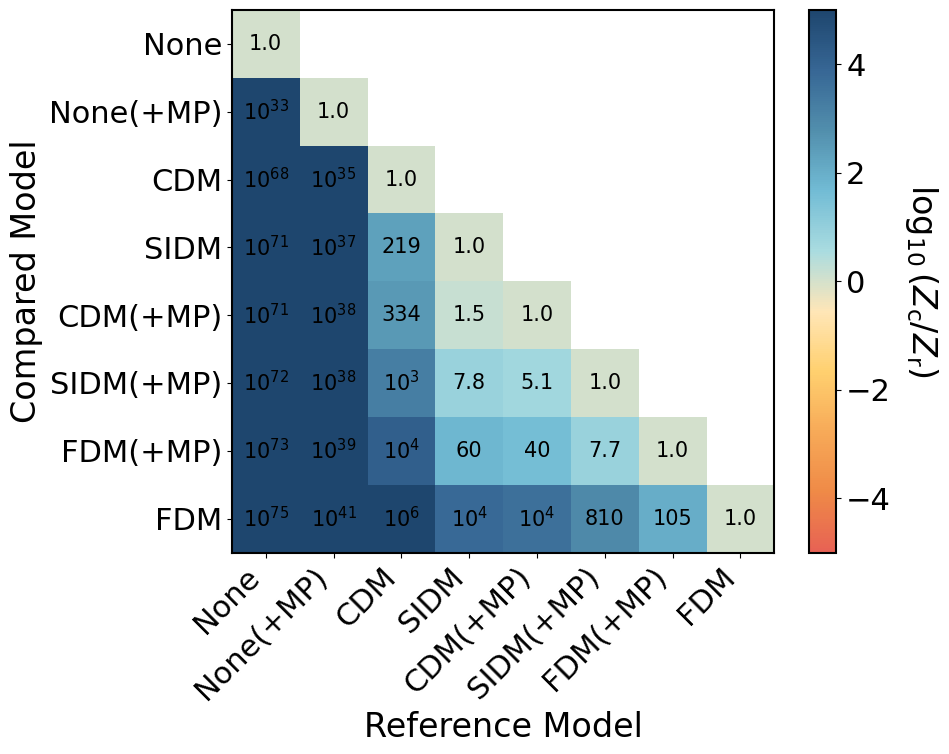

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# =========================================================
# =========================================================
# =========================================
# =========================================
def display_name(m):
    return m.replace('_mul', '(+MP)')
models = ['None', 'None_mul', 'CDM', 'SIDM', 'CDM_mul', 'SIDM_mul', 'FDM_mul', 'FDM']
# =========================================================
# =========================================================
res = combined_result
# res = combined_result['components']['A']
# res = combined_result['components']['B']
logZ = res['logZ']  # ln(Z)
models_use = [m for m in models if m in logZ]
# =========================================================
# =========================================================
ln10 = np.log(10.0)
logBF_df = pd.DataFrame(index=models_use, columns=models_use, dtype=float)
for comp in models_use:
    for ref in models_use:
        logBF_df.loc[comp, ref] = (logZ[comp] - logZ[ref]) / ln10
# =========================================================
# =========================================================
values = logBF_df.values.astype(float)
mask = np.tri(len(models_use), len(models_use), k=0, dtype=bool)
values[~mask] = np.nan
# =========================================================
# =========================================================
fig, ax = plt.subplots(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
im = ax.imshow(values, cmap=cmap256, norm=norm)
ax.set_xticks(np.arange(len(models_use)))
ax.set_yticks(np.arange(len(models_use)))
ax.set_xticklabels([display_name(m) for m in models_use])
ax.set_yticklabels([display_name(m) for m in models_use])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(len(models_use)):
    for j in range(len(models_use)):
        if i >= j and np.isfinite(values[i, j]):
            label = format_BF_from_log10(values[i, j])
            ax.text(j, i, label,
                    ha="center", va="center", color="black", fontsize=15)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10}\left(Z_{\rm c}/Z_{\rm r}\right)$', rotation=270, labelpad=35)
ax.set_xlabel("Reference Model")
ax.set_ylabel("Compared Model")
plt.tight_layout()
plt.show()

# Use only JWST systems

In [15]:
axis_type_name = "long_axis"
observations = choose_observation(axis_type_name)
exclude_names = {"J0630", "J0833", "J0429", "J1433"}
observations = [o for o in observations if o.get("name", "") not in exclude_names]
names = [o.get("name", "UNKNOWN") for o in observations]
print(f"Target Plot axis_type: {axis_type_name}")
print(f"Count Extracted observations {len(observations)} ")
print(names)


🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个

🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个
🎯 绘制 axis_type: long_axis
📊 提取观测点 5 个
['B1608', 'J0147', 'B2045', 'Q1131', 'B1422']


In [16]:
sim_samples = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type[axis_type_name],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul[axis_type_name],
)
# print(sim_samples.keys())
result_long_axis = kde_marginal_likelihood_2d_weighted(
    sim_samples,
    observations,
    ref_model="FDM_mul",
    bw_method="scott"
)
print(result_long_axis)

{'Z': {'None': 3.3083169999332453e-19, 'CDM': 8.478259755923922e-13, 'SIDM': 2.3966279468939587e-12, 'FDM': 8.004134234286674e-11, 'None_mul': 1.2179824225931232e-26, 'CDM_mul': 1.8218798714773885e-13, 'SIDM_mul': 1.0769135546520744e-12, 'FDM_mul': 1.4081639284212378e-11}, 'logZ': {'None': -42.552677166041796, 'CDM': -27.79610099764057, 'SIDM': -26.756958388671276, 'FDM': -23.24847783545326, 'None_mul': -59.67001668003015, 'CDM_mul': -29.333737344488206, 'SIDM_mul': -27.556921985922706, 'FDM_mul': -24.986149345540145}, 'BF_vs_ref': {'None': 2.3493834298414126e-08, 'CDM': 0.06020790324766605, 'SIDM': 0.1701952378215608, 'FDM': 5.6840926491140165, 'None_mul': 8.64943631924064e-16, 'CDM_mul': 0.012937981400503477, 'SIDM_mul': 0.0764764338097664, 'FDM_mul': 1.0}, 'log10_BF': {'None': -7.629046098643824, 'CDM': -1.2203464969221398, 'SIDM': -0.7690525959362274, 'FDM': 0.7546611481912243, 'None_mul': -15.063012194433457, 'CDM_mul': -1.8881334775319436, 'SIDM_mul': -1.116472371945999, 'FDM_mul

In [17]:
axis_type_name = "short_axis"
observations = choose_observation(axis_type_name)
exclude_names = {"J0029", "G0214"}
observations = [o for o in observations if o.get("name", "") not in exclude_names]
names = [o.get("name", "UNKNOWN") for o in observations]
print(f"Target Plot axis_type: {axis_type_name}")
print(f"Count Extracted observations {len(observations)} ")
print(names)


🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个

🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个
🎯 绘制 axis_type: short_axis
📊 提取观测点 6 个
['J2017', 'J2205', 'J0911', 'J1251', 'J1042', 'J0659']


In [18]:
sim_samples = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type[axis_type_name],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul[axis_type_name],
)
result_short_axis = kde_marginal_likelihood_2d_weighted(
    sim_samples,
    observations,
    ref_model="FDM_mul",
    bw_method="scott"
)
print(result_short_axis)

{'Z': {'None': 2.1604569502782426e-69, 'CDM': 8.58044477045845e-15, 'SIDM': 1.080487908146308e-12, 'FDM': 1.2791418156564693e-11, 'None_mul': 7.823259753954582e-36, 'CDM_mul': 1.2730137540866567e-11, 'SIDM_mul': 1.0316721452371325e-11, 'FDM_mul': 4.712168972969749e-12}, 'logZ': {'None': -158.1080516662121, 'CDM': -32.38929064470559, 'SIDM': -27.55360841000618, 'FDM': -25.08224662637784, 'None_mul': -80.83596203175377, 'CDM_mul': -25.08704889895047, 'SIDM_mul': -25.297255095072593, 'FDM_mul': -26.08087281008433}, 'BF_vs_ref': {'None': 4.584846092470785e-58, 'CDM': 0.0018209119451526796, 'SIDM': 0.22929736058793165, 'FDM': 2.7145499726218776, 'None_mul': 1.6602247921988525e-24, 'CDM_mul': 2.7015452149296877, 'SIDM_mul': 2.189378503095024, 'FDM_mul': 1.0}, 'log10_BF': {'None': -57.338675238469975, 'CDM': -2.7397110551160737, 'SIDM': -0.6396009443485351, 'FDM': 0.4336978410678308, 'None_mul': -23.779833105091257, 'CDM_mul': 0.4316122405889426, 'SIDM_mul': 0.3403208495512321, 'FDM_mul': 0.0

In [19]:
from Bayesian import combine_independent_bayes_results
combined_result = combine_independent_bayes_results(result_short_axis, result_long_axis)


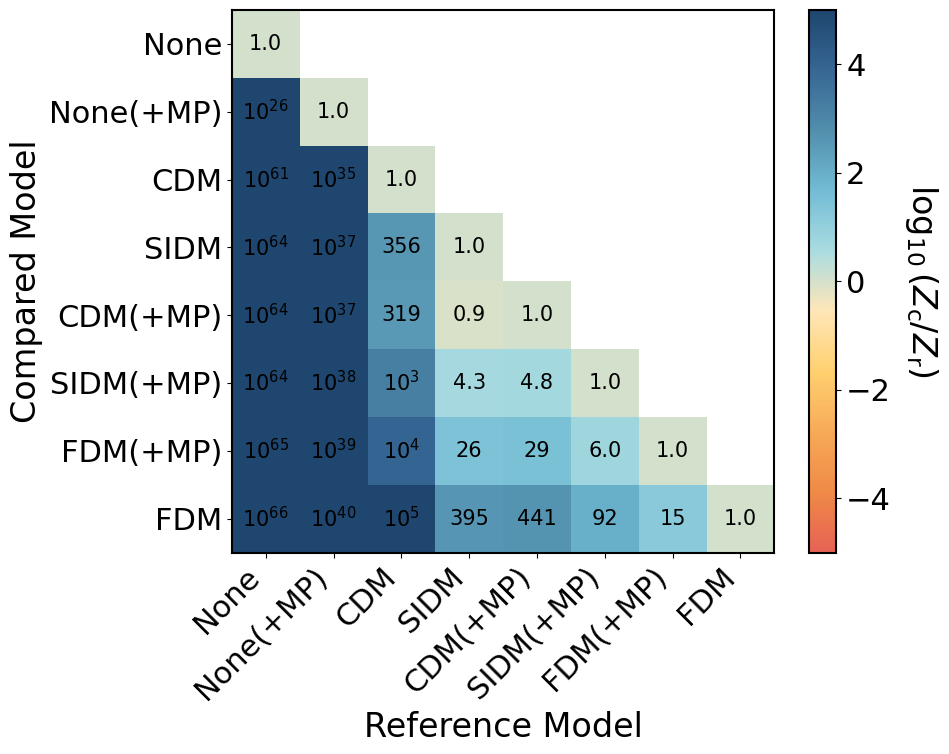

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# =========================================================
# =========================================================
# =========================================
# =========================================
def display_name(m):
    return m.replace('_mul', '(+MP)')
models = ['None', 'None_mul', 'CDM', 'SIDM', 'CDM_mul', 'SIDM_mul', 'FDM_mul', 'FDM']
# =========================================================
# =========================================================
res = combined_result
# res = combined_result['components']['A']
# res = combined_result['components']['B']
logZ = res['logZ']  # ln(Z)
models_use = [m for m in models if m in logZ]
# =========================================================
# =========================================================
ln10 = np.log(10.0)
logBF_df = pd.DataFrame(index=models_use, columns=models_use, dtype=float)
for comp in models_use:
    for ref in models_use:
        logBF_df.loc[comp, ref] = (logZ[comp] - logZ[ref]) / ln10
# =========================================================
# =========================================================
values = logBF_df.values.astype(float)
mask = np.tri(len(models_use), len(models_use), k=0, dtype=bool)
values[~mask] = np.nan
# =========================================================
# =========================================================
fig, ax = plt.subplots(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
im = ax.imshow(values, cmap=cmap256, norm=norm)
ax.set_xticks(np.arange(len(models_use)))
ax.set_yticks(np.arange(len(models_use)))
ax.set_xticklabels([display_name(m) for m in models_use])
ax.set_yticklabels([display_name(m) for m in models_use])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(len(models_use)):
    for j in range(len(models_use)):
        if i >= j and np.isfinite(values[i, j]):
            label = format_BF_from_log10(values[i, j])
            ax.text(j, i, label,
                    ha="center", va="center", color="black", fontsize=15)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10}\left(Z_{\rm c}/Z_{\rm r}\right)$', rotation=270, labelpad=35)
ax.set_xlabel("Reference Model")
ax.set_ylabel("Compared Model")
plt.tight_layout()
plt.show()

# Keep only DM-insensitive systems

In [28]:
axis_type_name = "long_axis"
observations = choose_observation(axis_type_name)
# observations = [o for o in observations if o.get("name", "") in in_names]
exclude_names = {"B2045", "Q1131", "J0147"}
observations = [o for o in observations if o.get("name", "") not in exclude_names]
names = [o.get("name", "UNKNOWN") for o in observations]
print(f"Target Plot axis_type: {axis_type_name}")
print(f"Count Extracted observations {len(observations)} ")
print(names)
sim_samples = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type[axis_type_name],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul[axis_type_name],
)
# print(sim_samples.keys())
result_long_axis = kde_marginal_likelihood_2d_weighted(
    sim_samples,
    observations,
    ref_model="FDM_mul",
    bw_method="scott"
)
print(result_long_axis)


🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个

🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个
🎯 绘制 axis_type: long_axis
📊 提取观测点 6 个
['B1608', 'J0429', 'J1433', 'B1422', 'J0833', 'J0630']


{'Z': {'None': 3.884500452345189e-12, 'CDM': 4.353905691440469e-12, 'SIDM': 5.691043741123934e-12, 'FDM': 3.034702324217399e-11, 'None_mul': 7.876710773915506e-12, 'CDM_mul': 8.884255107028077e-12, 'SIDM_mul': 8.797386313282496e-12, 'FDM_mul': 6.1523953129601705e-12}, 'logZ': {'None': -26.27402672407146, 'CDM': -26.15994781356197, 'SIDM': -25.89212745031989, 'FDM': -24.21832268421603, 'None_mul': -25.56711071367816, 'CDM_mul': -25.446740494974552, 'SIDM_mul': -25.45656644841481, 'FDM_mul': -25.81417962815632}, 'BF_vs_ref': {'None': 0.6313801787350033, 'CDM': 0.7076765178383224, 'SIDM': 0.9250126904452338, 'FDM': 4.93255418393666, 'None_mul': 1.2802673386937642, 'CDM_mul': 1.44403190222728, 'SIDM_mul': 1.429912394405247, 'FDM_mul': 1.0}, 'log10_BF': {'None': -0.1997090562751809, 'CDM': -0.15016521493937407, 'SIDM': -0.03385230904201409, 'FDM': 0.6930718646602554, 'None_mul': 0.10730066620769108, 'CDM_mul': 0.15957678797615624, 'SIDM_mul': 0.15530943061761332, 'FDM_mul': 0.0}, 'sigma_equ

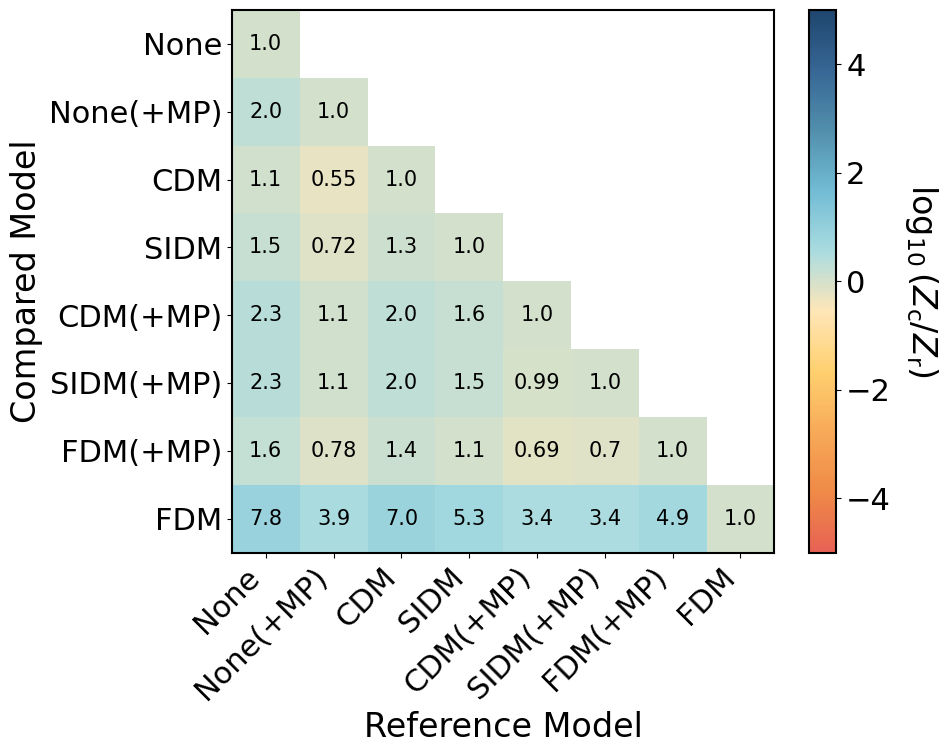

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# =========================================================
# =========================================================
# =========================================
# =========================================
def display_name(m):
    return m.replace('_mul', '(+MP)')
models = ['None', 'None_mul', 'CDM', 'SIDM', 'CDM_mul', 'SIDM_mul', 'FDM_mul', 'FDM']
# =========================================================
# =========================================================
res = result_long_axis
# res = combined_result['components']['A']
# res = combined_result['components']['B']
logZ = res['logZ']  # ln(Z)
models_use = [m for m in models if m in logZ]
# =========================================================
# =========================================================
ln10 = np.log(10.0)
logBF_df = pd.DataFrame(index=models_use, columns=models_use, dtype=float)
for comp in models_use:
    for ref in models_use:
        logBF_df.loc[comp, ref] = (logZ[comp] - logZ[ref]) / ln10
# =========================================================
# =========================================================
values = logBF_df.values.astype(float)
mask = np.tri(len(models_use), len(models_use), k=0, dtype=bool)
values[~mask] = np.nan
# =========================================================
# =========================================================
fig, ax = plt.subplots(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
im = ax.imshow(values, cmap=cmap256, norm=norm)
ax.set_xticks(np.arange(len(models_use)))
ax.set_yticks(np.arange(len(models_use)))
ax.set_xticklabels([display_name(m) for m in models_use])
ax.set_yticklabels([display_name(m) for m in models_use])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(len(models_use)):
    for j in range(len(models_use)):
        if i >= j and np.isfinite(values[i, j]):
            label = format_BF_from_log10(values[i, j])
            ax.text(j, i, label,
                    ha="center", va="center", color="black", fontsize=15)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10}\left(Z_{\rm c}/Z_{\rm r}\right)$', rotation=270, labelpad=35)
ax.set_xlabel("Reference Model")
ax.set_ylabel("Compared Model")
plt.tight_layout()
plt.show()

# Compare without splitting long/short axes?


🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个

🎯 绘制 axis_type: long_axis
📊 提取观测点 9 个

🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个

🎯 绘制 axis_type: short_axis
📊 提取观测点 8 个
🎯 合并 axis_type: long_axis + short_axis
📊 合并观测点 17 个
['B1608', 'J0147', 'J0429', 'J1433', 'B2045', 'Q1131', 'B1422', 'J0833', 'J0630', 'J2017', 'J2205', 'J0911', 'J1251', 'G0214', 'J1042', 'J0659', 'J0029']


✅ got logZ models: ['CDM', 'CDM_mul', 'FDM', 'FDM_mul', 'None', 'None_mul', 'SIDM', 'SIDM_mul']


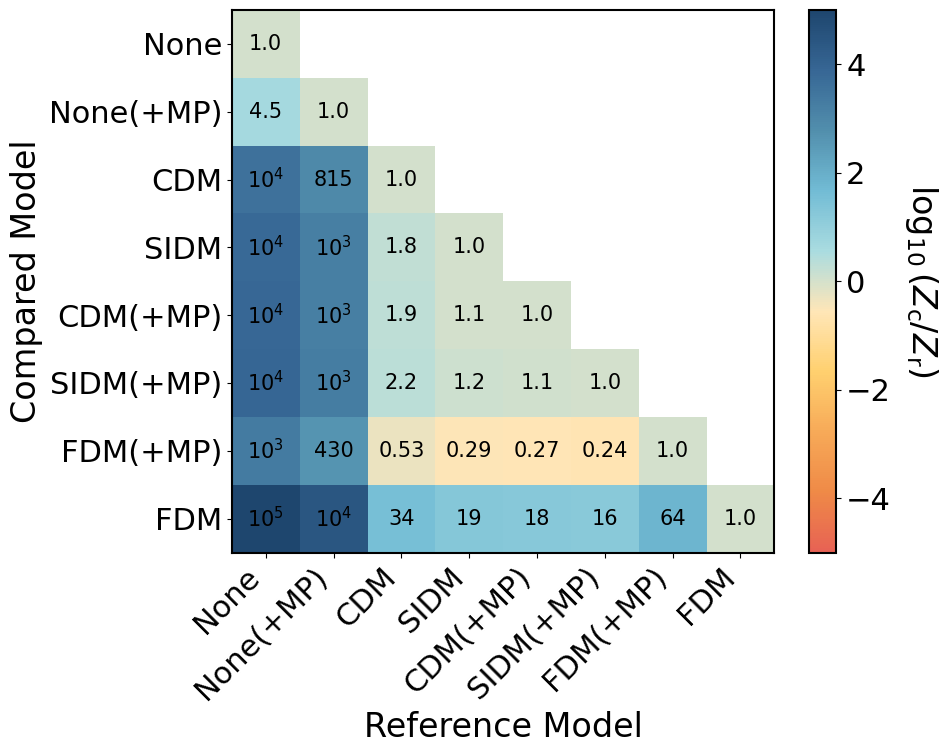

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# =========================================================
# =========================================================
def _get_first_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    raise KeyError(f"Cannot find any of keys {candidates} in dict keys={list(d.keys())}")
def concat_sim_samples(sim_a, sim_b):
    """
     build_sim_samples_for_axis_with_weights ()
    sim_a/sim_b: dict[model] -> dict(fields)
    Returns sim_all: dict[model] -> dict(fields)
    """
    sim_all = {}
    common_models = sorted(set(sim_a.keys()) & set(sim_b.keys()))
    if not common_models:
        raise ValueError("No overlapping models between sim_a and sim_b.")
    for m in common_models:
        A = sim_a[m]
        B = sim_b[m]
        k_phi = _get_first_key(A, ["phi", "phis"])
        k_R   = _get_first_key(A, ["R", "Rcusp", "rcusp", "R_cusp"])
        k_w   = _get_first_key(A, ["w", "weight", "weights"])
        phi = np.concatenate([np.asarray(A[k_phi]), np.asarray(B[k_phi])])
        R   = np.concatenate([np.asarray(A[k_R]),   np.asarray(B[k_R])])
        w   = np.concatenate([np.asarray(A[k_w]),   np.asarray(B[k_w])])
        sim_all[m] = {"phi": phi, "R": R, "w": w}
    return sim_all
# =========================================================
# =========================================================
def display_name(m):
    return m.replace("_mul", "(+MP)")
# =========================================================
# =========================================================
obs_long  = choose_observation("long_axis")
obs_short = choose_observation("short_axis")
observations_all = obs_long + obs_short
names_all = [o.get("name", "UNKNOWN") for o in observations_all]
print(f"Target Merging axis_type: long_axis + short_axis")
print(f"Count Merged observations {len(observations_all)} ")
print(names_all)
# =========================================================
# =========================================================
sim_long = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type["long_axis"],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul["long_axis"],
)
sim_short = build_sim_samples_for_axis_with_weights(
    merged_by_axis_type["short_axis"],
    ["None", "CDM", "SIDM", "FDM"],
    sim_dict_mul=merged_by_axis_type_mul["short_axis"],
)
sim_samples_all = concat_sim_samples(sim_long, sim_short)
# =========================================================
# =========================================================
result_all = kde_marginal_likelihood_2d_weighted(
    sim_samples_all,
    observations_all,
    ref_model="FDM_mul",
    bw_method="scott"
)
logZ = result_all["logZ"]  # ln(Z)
print("OK got logZ models:", list(logZ.keys()))
# =========================================================
# =========================================================
models_order = ["None", "None_mul", "CDM", "SIDM", "CDM_mul", "SIDM_mul", "FDM_mul", "FDM"]
models_use = [m for m in models_order if m in logZ]
if len(models_use) < 2:
    raise ValueError(f"Not enough models in logZ to build BF matrix. models_use={models_use}")
ln10 = np.log(10.0)
logBF_df = pd.DataFrame(index=models_use, columns=models_use, dtype=float)
for comp in models_use:
    for ref in models_use:
        logBF_df.loc[comp, ref] = (logZ[comp] - logZ[ref]) / ln10  # log10(Zc/Zr)
values = logBF_df.values.astype(float)
mask = np.tri(len(models_use), len(models_use), k=0, dtype=bool)
values[~mask] = np.nan
# cmap fallback
try:
    _cmap = cmap256
except NameError:
    _cmap = "viridis"
fig, ax = plt.subplots(figsize=(10, 8))
norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
im = ax.imshow(values, cmap=_cmap, norm=norm)
ax.set_xticks(np.arange(len(models_use)))
ax.set_yticks(np.arange(len(models_use)))
ax.set_xticklabels([display_name(m) for m in models_use])
ax.set_yticklabels([display_name(m) for m in models_use])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(len(models_use)):
    for j in range(len(models_use)):
        if i >= j and np.isfinite(values[i, j]):
            try:
                label = format_BF_from_log10(values[i, j])
            except NameError:
                label = f"{values[i,j]:+.2f}"
            ax.text(j, i, label, ha="center", va="center", color="black", fontsize=15)
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$\log_{10}\left(Z_{\rm c}/Z_{\rm r}\right)$', rotation=270, labelpad=35)
ax.set_xlabel("Reference Model")
ax.set_ylabel("Compared Model")
plt.tight_layout()
plt.show()